In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Create DataFrame from keyboard_actions.log

Log file is formatted as a csv file so pd.read_csv works like a charm

Indexed by timestamp of each action (should always be unique)

In [145]:
keyboard_df = pd.read_csv("logs/Zirui/keyboard_actions.log", names=['time', 'key', 'action'])

keyboard_df

,time,key,action
0,7.2376,'w',pressed
1,7.6604,'a',pressed
2,7.8563,'a',released
3,9.0524,'a',pressed
4,9.4064,'a',released
...,...,...,...
3575,670.2026,'a',released
3576,673.8301,Key.cmd,pressed
3577,674.1170,Key.tab,pressed
3578,674.2703,Key.tab,released


### Create DataFrame from mouse_actions.log

same deal

In [146]:
mouse_df = pd.read_csv("logs/Zirui/mouse_actions.log", names=['time', 'x', 'y', 'button', 'action'])

mouse_df

,time,x,y,button,action
0,0.0968,452,334,left,released
1,0.2963,452,335,None,None
2,0.2993,452,336,None,None
3,0.3005,453,336,None,None
4,0.3026,453,337,None,None
...,...,...,...,...,...
184105,677.4316,424,358,None,None
184106,677.4376,424,357,None,None
184107,677.4476,424,356,None,None
184108,677.4606,424,354,None,None


## Generate heatmap from mouse positions

In [154]:
# Instantiate this class using a DataFrame (parsed log file)
class MouseHeatmap:
    def __init__(self, mouse_df):
        self.df = mouse_df
        self.last_time, self.last_x, self.last_y = 0, 0, 0

        # Screen dimensions according to log min/max values
        self.screen_w_log = np.max(self.df.x) - np.min(self.df.x)
        self.screen_h_log = np.max(self.df.y) - np.min(self.df.y)

        # Use 1080p dimesnions if larger log file dimensions
        self.screen_w, self.screen_h = max(1920, self.screen_w_log), max(1080, self.screen_h_log)

        # Define heatmap dimensions and create empty 2D array (zeros)
        self.heatmap_w, self.heatmap_h = 100, 100
        self.heatmap_values = np.zeros((self.heatmap_w, self.heatmap_h))

        # Saturdation value used in normalization
        self.saturation = 10

    # Add a line of data to the heatmap (in List form)
    # Uses the passed line to find duration that the mouse was in the last position
    # Adds previous line of data (from last function call) to heat map and prepares the passed line
    def to_heatmap(self, line):
        # Find duration of mouse in last position
        value = line[0] - self.last_time
        # Add last line of data to heatmap
        self.heatmap_values[self.last_x, self.last_y] += value

        # Prepare passed line of data for heatmap
        self.last_time = line[0]

        # Normalize and clamp data if needed
        x_raw, y_raw = line[1], line[2]
        x = int((x_raw / self.screen_w) * (self.heatmap_w - 1))
        y = int((y_raw / self.screen_h) * (self.heatmap_h - 1))
        if x < 0: x = 0
        if x > (self.heatmap_w - 1): x = self.heatmap_w - 1
        if y < 0: y = 0
        if y > (self.heatmap_h - 1): y = self.heatmap_h - 1
        self.last_x, self.last_y = x, y

    # Show the heatmap generated from a specified minute of activity
    # Fails if minute is beyond the length of log file (TODO: fix this)
    def show_minute(self, min):
        # Refresh heatmap (reset to zeros)
        self.heatmap_values = np.zeros((self.heatmap_w, self.heatmap_h))

        # Calculate first and last second of minute
        last_sec = min * 60.0
        first_sec = last_sec - 60.0

        # Create a mask for specified minute
        df_mask = (self.df.time > first_sec) & (self.df.time < last_sec)

        # Iterate through each row of dataframe within specified minute
        for i in self.df[df_mask].index:
            line = self.df.iloc[i].values.tolist() # Convert row to List
            self.to_heatmap(line)

        # Normalize heatmap values (divide by max value)
        self.heatmap_values /= np.max(self.heatmap_values) 

        # Compress the heatmap
        # Calculate max saturation = (mean / deviation) * (1 / saturation)
        max_saturation = self.heatmap_values.mean() / (self.heatmap_values.std() * self.saturation)
        # Anything above max_saturation is clamped to max_saturation
        self.heatmap_values[self.heatmap_values > max_saturation] = max_saturation

        # Show heatmap
        plt.figure(figsize=(10, 10))
        plt.imshow(self.heatmap_values.T, cmap='cividis') # Need to transpose array to represent screen
        plt.show()

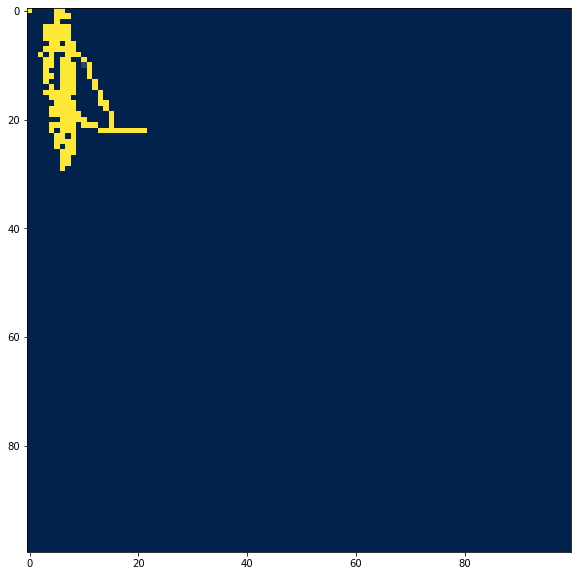

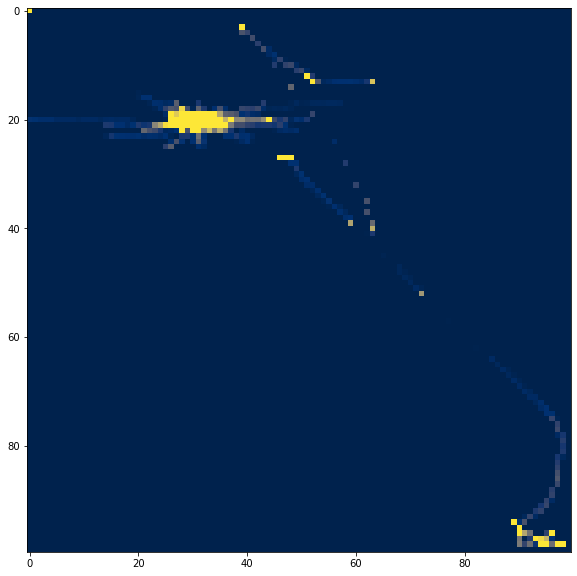

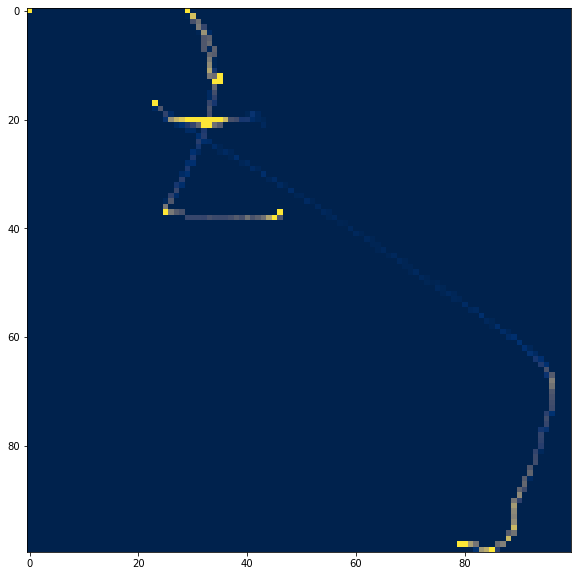

In [155]:
jon_mouse_df = pd.read_csv("logs/Jonathan/mouse_actions.log", names=['time', 'x', 'y', 'button', 'action'])
zirui_mouse_df = pd.read_csv("logs/Zirui/mouse_actions.log", names=['time', 'x', 'y', 'button', 'action'])
joseph_mouse_df = pd.read_csv("logs/Joseph/mouse_actions.log", names=['time', 'x', 'y', 'button', 'action'])

heatmap_jon = MouseHeatmap(jon_mouse_df)
heatmap_zirui = MouseHeatmap(zirui_mouse_df)
heatmap_joseph = MouseHeatmap(joseph_mouse_df)

heatmap_joseph.show_minute(1)
heatmap_jon.show_minute(1)
heatmap_zirui.show_minute(1)